In [1]:
import yfinance as yf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from torch import nn,tensor,float32,cuda,zeros
from torch import device as torch_device
from torch.utils.data import TensorDataset,DataLoader
from torch.nn import MSELoss
from torch.optim import Adam

In [2]:
device=torch_device("cuda" if cuda.is_available() else "cpu")

Params

In [3]:
windowsize=5

Import Data

In [4]:
stock=yf.download(tickers="NVDA",period="7d",interval="1m",multi_level_index=False,)
stock.drop("Volume",axis="columns",inplace=True)

C:\Users\tejes\AppData\Local\Temp\ipykernel_24680\1468470456.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock=yf.download(tickers="NVDA",period="7d",interval="1m",multi_level_index=False,)
[*********************100%***********************]  1 of 1 completed


In [5]:
stock.head()

,Close,High,Low,Open
Datetime,,,,
2025-10-13 13:30:00+00:00,188.669998,188.990005,187.880005,187.964996
2025-10-13 13:31:00+00:00,188.759995,189.259995,188.350006,188.639999
2025-10-13 13:32:00+00:00,188.755005,189.100006,188.453506,188.744995
2025-10-13 13:33:00+00:00,188.490005,189.141693,188.300003,188.740005
2025-10-13 13:34:00+00:00,187.770004,188.559998,187.750595,188.500000


In [6]:
X=stock[['Close','High','Low']].values
y=stock[['Open']].values

Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
X_scaler=StandardScaler()
y_scaler=StandardScaler()

X_scaled=X_scaler.fit_transform(X)
y_scaled=y_scaler.fit_transform(y)

Train Test Split

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_scaled,train_size=0.8,shuffle=False)

In [10]:
print("X_train Size:",len(X_train))
print("X_test Size",len(X_test))

X_train Size: 2171
X_test Size 543


Sliding Windows

In [11]:
def sliding_windows(x,y,size=4):
    out=[]
    for i in range(len(x)-size):
        out.append(x[i:i+size])
    return np.array(out),y[size:]

In [12]:
X_train_sliding,y_train_sliding=sliding_windows(X_train,y_train,size=windowsize)
X_test_sliding,y_test_sliding=sliding_windows(X_test,y_test,size=windowsize)

Datasets

In [13]:
train_dataset=TensorDataset(tensor(X_train_sliding,dtype=float32),tensor(y_train_sliding,dtype=float32))
test_dataset=TensorDataset(tensor(X_test_sliding,dtype=float32),tensor(y_test_sliding,dtype=float32))

Loaders

In [14]:
train_loader=DataLoader(train_dataset,pin_memory=cuda.is_available(),batch_size=16)
test_loader=DataLoader(test_dataset,pin_memory=cuda.is_available(),batch_size=128)

Model

In [15]:
class LSTM_Model(nn.Module):
    def __init__(self,hidden_units=32,num_layers=1):
        super(LSTM_Model,self).__init__()

        self.hidden_units=hidden_units
        self.num_layers=num_layers

        self.lstm_layer=nn.LSTM(input_size=3,num_layers=num_layers,hidden_size=hidden_units,batch_first=True)
        self.nn_block=nn.Sequential(
            nn.LazyLinear(out_features=64),
            nn.SELU(),
            nn.Linear(64,32),
            nn.SELU(),
            nn.Linear(32,1),
        )
    
    def forward(self,x):
        
        h0=zeros(self.num_layers, x.size(0), self.hidden_units).requires_grad_().to(device)
        c0=zeros(self.num_layers, x.size(0), self.hidden_units).requires_grad_().to(device)
        
        out,_=self.lstm_layer(x,(h0,c0))
        out=out[:, -1, :]
        out = self.nn_block(out)

        return out

In [16]:
model=LSTM_Model(hidden_units=128).to(device)
mse_loss=MSELoss().to(device)
optimizer=Adam(params=model.parameters(),lr=1e-5)

Validation Method

In [17]:
def validate():
    model.eval()
    y_pred=[]

    for idx,(x,y) in enumerate(test_loader):
        x=x.to(device)
        y=y.to(device)

        model.zero_grad()
            
        out=model(x)
        y_pred.extend(list(out.detach().cpu().numpy()))
    
    model.train()

    return r2_score(y_pred=y_pred,y_true=y_test_sliding)

Train

In [18]:
def train(epochs=10):
    
    losses=[]
    model.train()
    for epoch in range(epochs):

        epoch_losses=[]

        for idx,(x,y) in enumerate(tqdm(train_loader)):
            x=x.to(device)
            y=y.to(device)

            model.zero_grad()
            
            out=model(x)

            loss = mse_loss(out, y)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        
        losses.append(np.mean(epoch_losses))
        print(f"Validation R2:{validate()}")
    
    return losses

In [19]:
losses=train(20)

100%|██████████| 136/136 [00:00<00:00, 245.87it/s]


Validation R2:-0.6379653035327464


100%|██████████| 136/136 [00:00<00:00, 327.83it/s]


Validation R2:-0.5570936933213644


100%|██████████| 136/136 [00:00<00:00, 330.49it/s]


Validation R2:-0.46774030888457974


100%|██████████| 136/136 [00:00<00:00, 332.08it/s]


Validation R2:-0.36654468806990637


100%|██████████| 136/136 [00:00<00:00, 330.70it/s]


Validation R2:-0.24847113473275462


100%|██████████| 136/136 [00:00<00:00, 304.21it/s]


Validation R2:-0.11370579364670785


100%|██████████| 136/136 [00:00<00:00, 311.30it/s]


Validation R2:0.03695340319160678


100%|██████████| 136/136 [00:00<00:00, 306.49it/s]


Validation R2:0.20186079416165104


100%|██████████| 136/136 [00:00<00:00, 310.84it/s]


Validation R2:0.3727388892415521


100%|██████████| 136/136 [00:00<00:00, 263.22it/s]


Validation R2:0.5396058043405807


100%|██████████| 136/136 [00:00<00:00, 291.30it/s]


Validation R2:0.6903111109772866


100%|██████████| 136/136 [00:00<00:00, 300.04it/s]


Validation R2:0.8113184087115345


100%|██████████| 136/136 [00:00<00:00, 290.15it/s]


Validation R2:0.8970071783204396


100%|██████████| 136/136 [00:00<00:00, 307.82it/s]


Validation R2:0.9471335222667349


100%|██████████| 136/136 [00:00<00:00, 308.44it/s]


Validation R2:0.9690888294233172


100%|██████████| 136/136 [00:00<00:00, 307.84it/s]


Validation R2:0.9737706376526613


100%|██████████| 136/136 [00:00<00:00, 300.17it/s]


Validation R2:0.971005465115812


100%|██████████| 136/136 [00:00<00:00, 302.19it/s]


Validation R2:0.9667326996168982


100%|██████████| 136/136 [00:00<00:00, 306.12it/s]


Validation R2:0.9633592508427374


100%|██████████| 136/136 [00:00<00:00, 304.76it/s]

Validation R2:0.9613137688838934


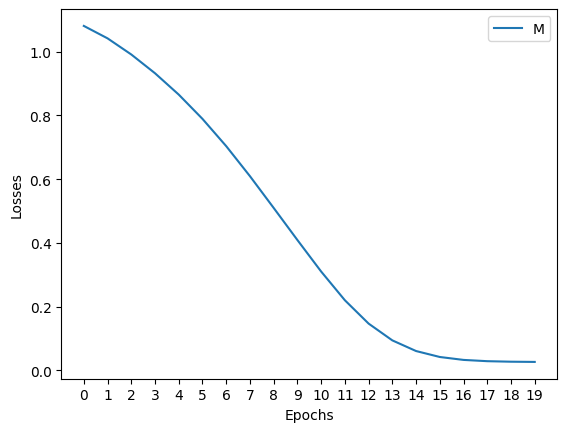

In [20]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend("MSE Loss")
plt.xticks(np.arange(len(losses)))
plt.show()

In [21]:
def test():
    model.eval()
    y_pred=[]

    for idx,(x,y) in enumerate(tqdm(test_loader)):
        x=x.to(device)
        y=y.to(device)

        model.zero_grad()
            
        out=model(x)
        y_pred.extend(list(out.detach().cpu().numpy()))
    
    return y_pred

In [22]:
y_pred=y_scaler.inverse_transform(test())
y_true=y_scaler.inverse_transform(y_test_sliding)

100%|██████████| 5/5 [00:00<00:00, 482.26it/s]


Plotting

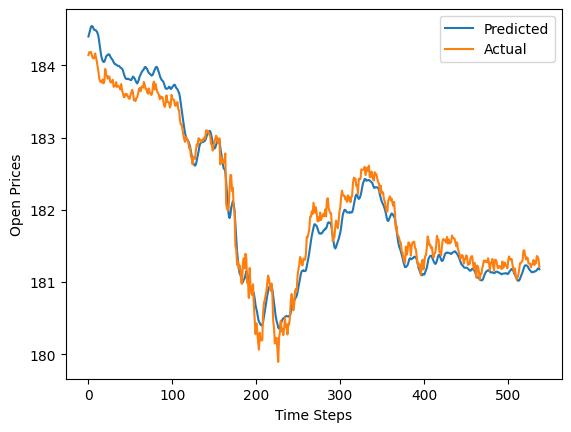

In [23]:
plt.plot(y_pred)
plt.plot(y_true)
plt.xlabel("Time Steps")
plt.ylabel("Open Prices")
plt.legend(['Predicted','Actual'])
plt.show()

In [24]:
print("R2 Score:",r2_score(y_pred=y_pred,y_true=y_true))

R2 Score: 0.9613137688838935


Ups and Downs

In [25]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix,ConfusionMatrixDisplay

In [26]:
def ups_and_downs(y):
    out=[]
    for i in range(len(y)-1):
        if(y[i]<y[i+1]):
            out.append(1)
        else:
            out.append(-1)
    return out

In [27]:
direction_pred=ups_and_downs(y_pred)
direction_true=ups_and_downs(y_true)

Accuracy Score: 0.6536312849162011
Precision Score: 0.6050420168067226
Recall Score: 0.6101694915254238
F1 Score: 0.6075949367088608


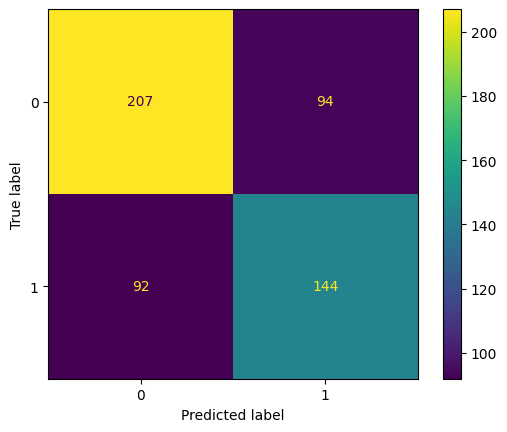

In [28]:
print("Accuracy Score:",accuracy_score(y_true=direction_true,y_pred=direction_pred))
print("Precision Score:",precision_score(y_true=direction_true,y_pred=direction_pred))
print("Recall Score:",recall_score(y_true=direction_true,y_pred=direction_pred))
print("F1 Score:",f1_score(y_true=direction_true,y_pred=direction_pred))
cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=direction_true,y_pred=direction_pred))
cm.plot()